# <center><span> Gene network analysis with microtom metabolite data </span> </center>
## <center> ABE 4662: Project 2 </center>
### <center> Bryce Askey </center>
### <center> 11/23/2020 </center>

Previously, I presented a workflow for a simple gene expression analysis. Using the Pearson Correlation Coefficient method, I correlated a set of genes against each other to determine their relatedness. I then using the network which I constructed to identfity putative interactions between genes, as well as hub genes which were correlated with a high number of other genes. This gene network was constructed using only transcriptomic data, which describes the level of gene expression in an organism. However, more significant conclusions can be drawn from a gene network if phenotypic data is incorporated. Incorporation of phenotypic data transforms a gene network into a co-expression network, and allows for the connection of gene expression to phenotypic traits. In more well-characterized organisms, a co-expression network can be used to elucidate the complex pathways responsible for the expression of phenotypes, and in less well-characterized organisms, it can be used to identify novel genes that likely play a role in determining phenotype. The paper which I am using the data from for this project reports metabolite accumulation data for the same set of tissues which transcriptomic data was collected from. 

<img src="fig1.PNG" width="800"><br/>
Illustration of tissue samples taken to generate gene expression dataset for MicroTom (Li et al., 2020).

Plant metabolites include a variety of compounds, such as amino acids, flavonoids, hormones, any many others. These compounds play important roles in primary and secondary metabolism (e.g. energy production and consumption), growth and development, and signaling. Because of the significant role that metabolites play in so many plant processes, their accumulation in plant tissues changes signficantly over the lifespan of the plant. Thus, each tissue of a plant (e.g. leaves, roots, fruit) at each stage in a plant's life, has its own unique metabolite signature. These metabolites are significant for growers because they play an integral role in ensuring plant health, and also to consumers, as metabolites affect the taste and nutrition of the fruit produced by a plant. This is very true for tomato, which is known to undergo significant metabolic changes in multiple tissues during its growth and development. 

In this project, I will describe a workflow for analysis and interpretation of metabolite data. Specifically, I will recreate the clustering workflow described by Li et al. to separate metabolites in distinct clusters which vary in accumulation with time and tissue sampled. I will import a subset of the metabolite data from an excel file, where it is reported in units of peak area. I will then perform a Principal Component Analysis (PCA) of the data to summarize it into 2 dimensions, in which it is easier to illustrate the clustering workflow. As I found the distribution of metabolite data to be severely skewed with several outliers, I will also demonstrate a method for data normalization called quantile normalization. Finally, I will demonstrate the K-means clustering workflow on the 2D PCA data, and then apply it to the full original dataset to cluster the metabolites I selected. This analysis will serve as precursory step in incorporating this metabolite data into a co-expression network.

In [1]:
import pandas as pd
import numpy as np
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(rc={'figure.figsize':(8,8)})
import IPython
import random as rd
import copy
import time
import math
from sklearn.decomposition import PCA
from sklearn import preprocessing

To make the dataset more manageable, I will only be working a subset of it. Li et al. reported 10 clusters of metabolites, so I will choose 4 clusters to pull out metabolites from: 1 (roots), 4 (leaves), 7 (green fruit), and 10 (ripening fruit). The following code block extracts IDs for metabolites in these clusters from the microtomMetaboliteClusters.xslx file, and saves them in a separate .csv file that is much smaller in size. If the metClusterData.csv file has already been created, this does not need to be ran.

Load metabolite IDs and cluster data from metClusterData.csv file, and metabolite accumulation data from microtomMetaboliteAccumulation.xlsx. Print the first 5 rows of the accumulation dataframe to view its structure.

In [2]:
metClusterData = pd.read_csv("metClusterData.csv")
metConcData = pd.read_excel("microtomMetaboliteAccumulation.xlsx")
metConcData.head()

,Index,Q1 (Da),Q3 (Da),Rt (min),Molecular Weight (Da),Ionization model,KEGG ID,Compound name,Class,R30,...,L85,10DPA,20DPA,IMG,MG,Br,Br3,Br7,Br10,Br15
0,pmf0352,279.1705,86.0964,3.21,278.1705,[M+H]+,-,4beta-Hydroxy-11-O-(2'-pyrolylcarboxy)epilupinine,Alkaloids,9.633333e+05,...,9.906667e+05,6.260000e+05,1.015000e+06,1.233333e+06,8.806667e+05,1.100667e+06,8.036667e+05,7.923333e+05,7.033333e+05,1.106000e+06
1,pmf0414,414.3000,396.2000,4.25,413.3000,[M+H]+,-,Tomatidenol,Alkaloids,6.866667e+05,...,7.130000e+05,5.243333e+05,3.290000e+05,3.266667e+05,2.623333e+05,2.726667e+05,1.343333e+05,6.226667e+04,6.486667e+04,5.256667e+04
2,pmf0460,563.0000,490.0000,3.96,562.0000,[M+H]+,-,Tomatidine-O-rhamnoside,Alkaloids,7.796667e+04,...,3.953333e+04,5.460000e+05,6.726667e+05,4.223333e+06,8.900000e+06,4.296667e+06,2.240000e+06,5.293333e+05,1.304333e+06,4.653333e+05
3,pmf0467,595.0000,255.1000,3.70,594.0000,[M+H]+,-,Tomatidine derivative,Alkaloids,3.246667e+07,...,9.056667e+05,3.490000e+06,2.306667e+06,3.296667e+06,3.506667e+06,1.386667e+06,9.433333e+05,3.876667e+05,5.393333e+05,6.880000e+05
4,pmf0487,872.3000,416.3000,4.33,871.3000,[M+H]+,-,β2-Tomatidine,Alkaloids,3.296667e+06,...,3.803333e+06,4.260000e+06,4.413333e+06,4.273333e+06,3.966667e+06,3.440000e+06,2.633333e+06,2.026667e+06,2.710000e+06,2.616667e+06


Filter accumulation dataframe by metabolite ID to remove any metabolites not in cluster 1, 4, 7, or 10. Add cluster data as a new column in the accumulation dataframe. Print the first 5 rows of the accumulation dataframe to check that cluster data has been added correctly. Although not shown, this cluster data can be used to validate the manual implementation of the k-means clustering algorithm in this notebook.

In [3]:
metData = metConcData[metConcData.Index.isin(metClusterData.metID)]
metData = metData.reset_index(drop=True)
metData.insert(0, column="Cluster", value=np.zeros(metData.shape[0]))
for row in range(0, metData.shape[0]):
    metID = metData.iloc[row,1]
    metCluster = metClusterData.query("metID==@metID")
    metData.iloc[row,0] = str(metCluster.iloc[0,0])
metData.head()

,Cluster,Index,Q1 (Da),Q3 (Da),Rt (min),Molecular Weight (Da),Ionization model,KEGG ID,Compound name,Class,...,L85,10DPA,20DPA,IMG,MG,Br,Br3,Br7,Br10,Br15
0,4,pmf0352,279.17050,86.0964,3.21,278.17050,[M+H]+,-,4beta-Hydroxy-11-O-(2'-pyrolylcarboxy)epilupinine,Alkaloids,...,9.906667e+05,6.260000e+05,1.015000e+06,1.233333e+06,8.806667e+05,1.100667e+06,8.036667e+05,7.923333e+05,7.033333e+05,1.106000e+06
1,7,pmf0460,563.00000,490.0000,3.96,562.00000,[M+H]+,-,Tomatidine-O-rhamnoside,Alkaloids,...,3.953333e+04,5.460000e+05,6.726667e+05,4.223333e+06,8.900000e+06,4.296667e+06,2.240000e+06,5.293333e+05,1.304333e+06,4.653333e+05
2,1,pmf0467,595.00000,255.1000,3.70,594.00000,[M+H]+,-,Tomatidine derivative,Alkaloids,...,9.056667e+05,3.490000e+06,2.306667e+06,3.296667e+06,3.506667e+06,1.386667e+06,9.433333e+05,3.876667e+05,5.393333e+05,6.880000e+05
3,10,pmf0500,1092.65800,1032.5000,3.96,1091.65800,[M+H]+,-,Lycoperoside B,Alkaloids,...,1.041597e+05,2.403333e+06,3.150000e+06,4.646667e+06,6.520000e+06,9.236667e+06,1.652667e+07,1.300667e+07,1.664333e+07,1.184333e+07
4,1,pmf0422,432.10001,273.2000,3.69,431.10001,[M+H]+,-,Hydroxytomatidine,Alkaloids,...,1.416667e+06,4.266667e+06,2.890000e+06,3.696667e+06,4.183333e+06,1.810000e+06,5.053333e+05,1.620000e+05,3.843333e+05,2.456667e+05


Before any analysis, I will first do some preliminary exploration of the dataset to understand how it is distributed. Create a scatterplot matrix with data from 3 diverse samples - R45, L45, and BR15.

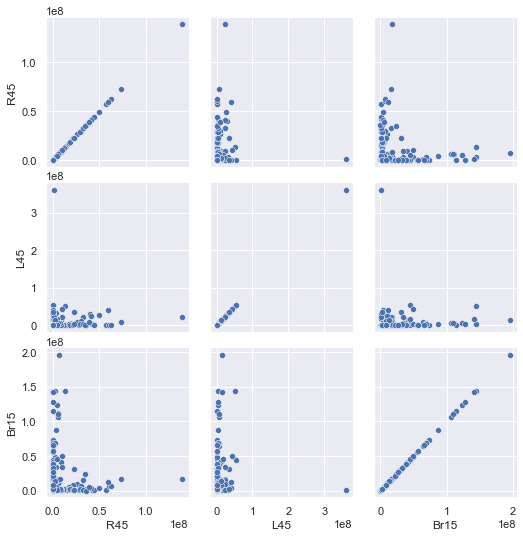

In [4]:
distGraph = sns.PairGrid(data=metData, vars=["R45", "L45", "Br15"])
distGraph.map(sns.scatterplot)

As is shown in the scatterplots, this dataset is skewed with several significant outliers. I want to take a closer look at what some of these outlier metabolites could be.

In [5]:
# Search for most highly accumulated metabolite in roots (R45)
metData[metData.R45 == metData.R45.max()]
# Phospholipid precursor - lysophosphatidylcholine 

,Cluster,Index,Q1 (Da),Q3 (Da),Rt (min),Molecular Weight (Da),Ionization model,KEGG ID,Compound name,Class,...,L85,10DPA,20DPA,IMG,MG,Br,Br3,Br7,Br10,Br15
142,1,pmf0450,520.3,184.2,8.23,519.3,[M+H]+,-,LPC(1-acyl 18:2),Lipids,...,1.243667e+07,67700000.0,5.636667e+07,2.746667e+07,2.866667e+07,20400000.0,1.103333e+07,12200000.0,16600000.0,16700000.0


In [6]:
# Search for most highly accumulated metabolite in leaves (L45)
metData[metData.L45 == metData.L45.max()]
# Lignin precursor

,Cluster,Index,Q1 (Da),Q3 (Da),Rt (min),Molecular Weight (Da),Ionization model,KEGG ID,Compound name,Class,...,L85,10DPA,20DPA,IMG,MG,Br,Br3,Br7,Br10,Br15
247,4,pmf0397,369.1,147.1,2.07,370.1,[M-H]-,-,Sinapaldehyde glucoside,Polyphenols,...,2.913333e+08,578333.333333,540333.333333,279000.0,338333.333333,555000.0,1204000.0,908000.0,1.158333e+06,832666.666667


In [7]:
# Search for most highly accumulated metabolite in ripening fruit (Br15)
metData[metData.Br15 == metData.Br15.max()]
# Glutamate - amino acid

,Cluster,Index,Q1 (Da),Q3 (Da),Rt (min),Molecular Weight (Da),Ionization model,KEGG ID,Compound name,Class,...,L85,10DPA,20DPA,IMG,MG,Br,Br3,Br7,Br10,Br15
49,10,pme0013,146.1,102.0,0.74,147.0532,[M-H]-,C00025,L-Glutamic acid,Amino acid and derivatives,...,17500000.0,1.763333e+07,1.563333e+07,1.093333e+07,11400000.0,1.078333e+07,4.046667e+07,160000000.0,63600000.0,1.963333e+08


These outlier metabolites make biological sense, so it's likely that they are not errors in data entry. Therefore, they should be preserved in downstream analyses. Normalization can be applied to deal with these outliers, as well as the uneven distribution of the nonoutlier data. Although all of the units of the dataset are identical (peak area), normalization is necessary here because the metabolites included serve a diverse set of physiological processes. For example, the concentration of an amino acid (e.g. glutamate) will be multiple orders of magnitude larger than the concentration of a hormone (e.g. abscisic acid). To demonstrate the importance of data normalization, I'll first fit a PCA model to the unnormalized dataset. Notice that the first two components are only able to explain around 67% of the variance in the data.

[Text(0.5, 0, 'PC1 (42.86%)'), Text(0, 0.5, 'PC2 (25.38%)')]

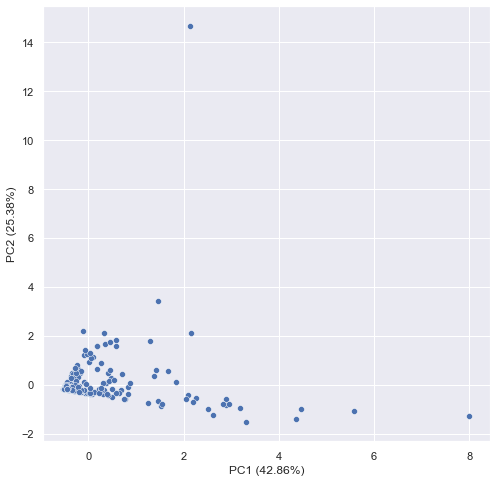

In [8]:
pcaData = metData.iloc[:, 10:30]
pcaModel = PCA(n_components=3, whiten=True)
pcaModel.fit(pcaData)
pcaResults = pcaModel.transform(pcaData)
pcaResults = pd.DataFrame(pcaResults, columns=["PC1", "PC2", "PC3"])
pcaResults = pd.concat([metData.iloc[:, 0:10], pcaResults], axis=1)
pcaPlot2D = sns.scatterplot(data=pcaResults, x="PC1", y="PC2")
pcaPlot2D.set(xlabel="PC1 (" + str(round(pcaModel.explained_variance_ratio_[0]*100, 2)) + "%)",
            ylabel="PC2 (" + str(round(pcaModel.explained_variance_ratio_[1]*100, 2)) + "%)")

I'll apply a data normalization method known as quantile normalization. I chose this method based on the explanation of different normalization provided by the scikit-learn package at this URL: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

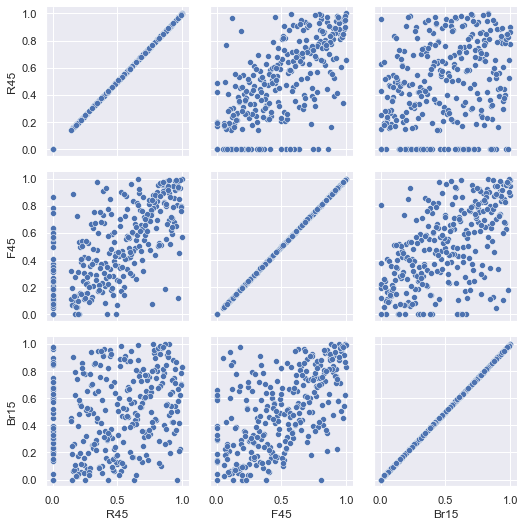

In [9]:
# Perform quantile transformation of data
TF = preprocessing.QuantileTransformer()
pcaDataTF = TF.fit_transform(pcaData)

# Reformat transformed data so distribution graphs can be regenerated 
metDataTF = metData.iloc[:, 0:10]
metDataTF = pd.concat([metDataTF, pd.DataFrame(pcaDataTF, columns=metData.columns[10:30])], axis=1)

# Plot pairwise distribution with transformed data
distGraphTF = sns.PairGrid(data=metDataTF, vars=["R45", "F45", "Br15"])
distGraphTF.map(sns.scatterplot)

The PCA model fit to the normalized dataset is able to explain a much greater percentage of the variance in the dataset - the first 2 components capture 84% of the variance.

[Text(0.5, 0, 'PC1 (70.23%)'), Text(0, 0.5, 'PC2 (14.14%)')]

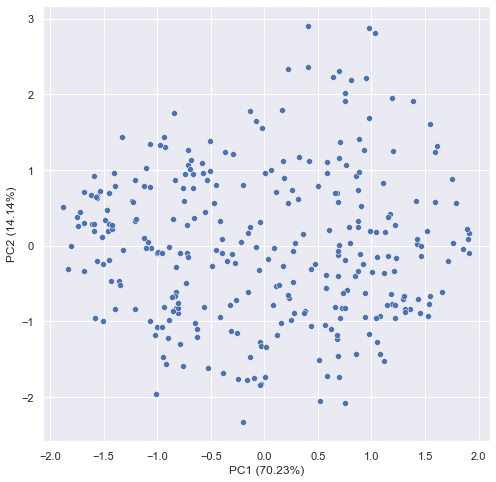

In [10]:
pcaModel = PCA(n_components=2, whiten=True)
pcaModel.fit(pcaDataTF)
pcaResults = pcaModel.transform(pcaDataTF)
pcaResults = pd.DataFrame(pcaResults, columns=["PC1", "PC2"])
pcaResults = pd.concat([metDataTF.iloc[:, 0:10], pcaResults], axis=1)
pcaPlot = sns.scatterplot(data=pcaResults, x="PC1", y="PC2")
pcaPlot.set(xlabel="PC1 (" + str(round(pcaModel.explained_variance_ratio_[0]*100, 2)) + "%)",
            ylabel="PC2 (" + str(round(pcaModel.explained_variance_ratio_[1]*100, 2)) + "%)")

To separate the datapoints into clusters, a k-means clustering algorithm will be applied. To aid in visualization, this algorithm will first be applied to the PCA summarized dataset, which has reduced the number of dimensions from 20 to 2.

K-means clustering separates data into n clusters based on the distance between each point and a cluster center. Distance can be calculated a variety of ways, but it is most common to use Euclidian distance.

The general equation for calculating Euclidian distance between 2 points is as follows:
\begin{equation}
    \large d(p,q) = \sqrt{\sum_{i=1}^n (q_{i} - p_{i})^2}
\end{equation}

Notice that in 2D space (n=2), this is the equivalent of the Pythogorean theorem-based distance formula:
\begin{equation}
    \large d(p,q) = \sqrt{(q_{x}-p_{x})^2 + (q_{y}-p_{y})^2}
\end{equation}

In higher dimensional space, distance is harder to visualize and a bit more abstract, but can still be calculated using the Euclidian distance formula.

The k-means clustering algorithm uses an interative process that can be summarized into 4 steps:
<ol>
<li>Randomly (or pseudorandomly) initialize n cluster centers in the feature space.</li>
<li>Calculate the Euclidian distance of each datapoint to each cluster center.</li>
<li>Assign each datapoint to its nearest cluster center based on Euclidian distance.</li>
<li>Recalculate cluster center locations by taking the mean location of all datapoints included in the cluster.</li>
</ol>

Step 1 only needs to be completed once per run, but steps 2-4 are repeated until the algorithm converges (i.e. the cluster centers stop moving). In the following code block, I've separated each of these steps into its own function. There is also a function that I've created to more easily make plots that illustrate this process.

In [11]:
# Step 1: Initialize n cluster centers in random, but evenly distributed locations
def initCenters(clusterData, numClusters):
    clusterCenters = pd.DataFrame(index=range(0,numClusters), columns=clusterData.columns)
    for dim in range(0, clusterData.shape[1]):
        dimMin = min(clusterData.iloc[:, dim]) 
        dimMax = max(clusterData.iloc[:, dim])
        dimInc = (dimMax - dimMin)/(numClusters + 1)
        dimValues = np.zeros(numClusters)        
        for cluster in range(0, numClusters):
            dimValues[cluster] = dimMin + dimInc*(cluster + 1)
        rd.shuffle(dimValues)
        for cluster in range(0, numClusters):
            clusterCenters.iloc[cluster, dim] = dimValues[cluster]
    return(clusterCenters)

# Step 2: Calculate Euclidian distance from each point to each cluster
def calcEucDist(clusterData, clusterCenters):
    eucDist = pd.DataFrame(index=range(0, clusterData.shape[0]), columns=range(0,clusterCenters.shape[0]))
    for cluster in range(0, clusterCenters.shape[0]):
        initial = list(clusterCenters.iloc[cluster, :])
        for point in range(0, clusterData.shape[0]):
            totalDist = 0
            for dim in range(0, clusterData.shape[1]):
                dimDist = (clusterCenters.iloc[cluster, dim] - clusterData.iloc[point, dim])**2
                totalDist = totalDist + dimDist
            eucDist.iloc[point, cluster] = round(math.sqrt(totalDist), 5)
    return(eucDist)

# Step 3: Associate each point with its closest cluster
def assocPoints(clusterData, eucDist, clusterCenters):
    clusterResults = copy.copy(clusterData)
    clusterResults["Cluster"] = np.nan
    for point in range(0, eucDist.shape[0]):
        cluster = list(eucDist.iloc[point, :]).index(min(eucDist.iloc[point, :]))
        clusterResults.Cluster[point] = cluster
    return(clusterResults)

# Step 4: Recalculate cluster centers
def recalcCenters(clusterResults, clusterCenters):
    updatedCenters = copy.copy(clusterCenters)
    for cluster in range(0, clusterCenters.shape[0]):
        clusterPoints = clusterResults[clusterResults.Cluster == cluster]
        for dim in range(0, clusterCenters.shape[1]):
            updatedCenters.iloc[cluster, dim] = clusterPoints.iloc[:, dim].mean()
    return(updatedCenters)

# Prepare data for plotting and create scatterplot showing both cluster centers and datapoints
def createPlot(clusterData, clusterCenters):
    plotClusterData = copy.copy(clusterData)
    if "Cluster" not in plotClusterData.columns:
        plotClusterData["Cluster"] = "NA"
    plotClusterData["Class"] = "Data"
    plotClusterCenters = copy.copy(clusterCenters)
    plotClusterCenters["Cluster"] = range(0, plotClusterCenters.shape[0])
    plotClusterCenters["Class"] = "Center"
    plotData = plotClusterCenters.append(plotClusterData, ignore_index=True)
    if plotData["Cluster"].dtypes == "float64":
        plotData = plotData.astype({"Cluster":int})
        plotData = plotData.astype({"Cluster":str})

    # Create plot
    kMeansPlot = sns.scatterplot(data=plotData, x="PC1", y="PC2", hue="Cluster", size="Class", sizes=(40,400))
    kMeansPlot.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0, frameon=False)
    kMeansPlot.set(xlabel="PC1 (" + str(round(pcaModel.explained_variance_ratio_[0]*100, 2)) + "%)",
                ylabel="PC2 (" + str(round(pcaModel.explained_variance_ratio_[1]*100, 2)) + "%)")
    return(kMeansPlot)

To run the k-means clustering algorithm, these functions can be called from within a for loop. The modulo operator-based if statements in this loop are used to split up the function calls so that a new plot can be generated showing the algorithm in action. Instead of testing for convergence, the number of iterations that this algorithm runs through is manually specified.

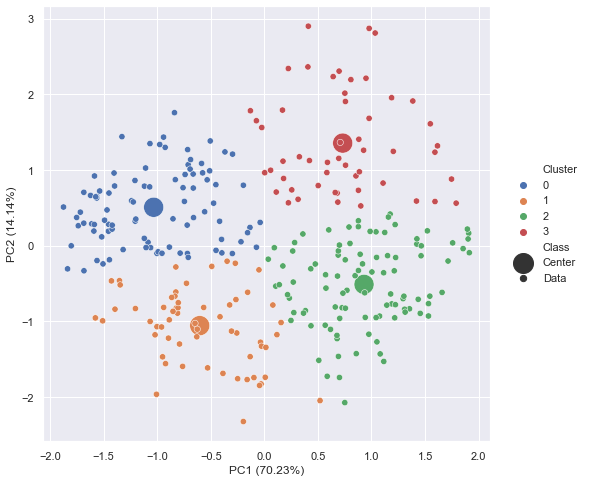

In [12]:
clusterData = pcaResults.iloc[:, 10:12]
for i in range(0, 30):
    if i == 0:
        clusterCenters = initCenters(clusterData, 4)
        createPlot(clusterData, clusterCenters)
    elif i % 3 == 1:
        if "Cluster" in clusterData.columns:
            clusterData = clusterData.drop("Cluster", axis=1)
        createPlot(clusterData, clusterCenters)
    elif i % 3 == 2:
        eucDist = calcEucDist(clusterData, clusterCenters)
        clusterData = assocPoints(clusterData, eucDist, clusterCenters)
        createPlot(clusterData, clusterCenters)
    else:
        clusterCenters = recalcCenters(clusterData, clusterCenters)
        createPlot(clusterData, clusterCenters)
    IPython.display.clear_output(wait=True)
    plt.show()
    plt.close()
    time.sleep(1)

Finally, k-means clustering isn't limited to just a 2D dataset. To demonstrate this, I will apply the k-means clustering algorithm to the original (but normalized) 20-dimension metabolite dataset. The same functions (except for createPlot) can be applied here, as they were written to be generalizable to a dataset of any dimension.

In [13]:
# K-means clustering isn't limited to just 2D
clusterData = pd.DataFrame(pcaDataTF)
clusterData.columns = pcaData.columns
for i in range(0, 50):
    if i == 0:
        clusterCenters = initCenters(clusterData, 4)
    else:
        if "Cluster" in clusterData.columns:
            clusterData = clusterData.drop("Cluster", axis=1)
        eucDist = calcEucDist(clusterData, clusterCenters)
        clusterData = assocPoints(clusterData, eucDist, clusterCenters)
        clusterCenters = recalcCenters(clusterData, clusterCenters)

The results of this clustering can be visualized with a heatmap. Notice that 4 distinct clusters, or blocks of metabolites, form in the heatmap.

<AxesSubplot:>

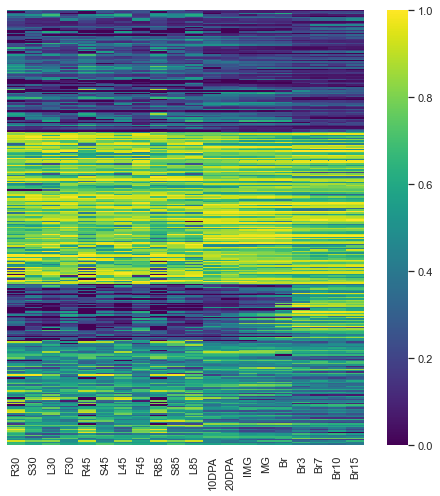

In [14]:
# First export the data as a .csv file
metDataTF["Cluster"] = clusterData["Cluster"]
metDataTF.to_csv(path_or_buf="metDataTF.csv", index=False)

# Draw heatmap with data sorted into clusters as determined by k-means clustering
clusterData = clusterData.sort_values(by="Cluster")
clusterData = clusterData.drop("Cluster", axis=1)
sns.heatmap(data=clusterData, yticklabels=False, cmap="viridis")